<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/Asg2/C_mixup_lbl_smoothing_cutout_tta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C. Write a colab to demonstrate the mixup, label smoothing, cutout  and test time augmentation with proper ablation studies on a small data set (cifar? etc.,,.) - check slides for hints. you can use fastai. 

In [22]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.6/dist-packages (2.0.13)


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

import numpy
import matplotlib.pyplot as plt
import torch

In [12]:
#export
from fastai.basics import *
from fastai.callback.progress import *
from fastai.vision.core import *
from fastai.vision.models.xresnet import *

from torch.distributions.beta import Beta

## Mixup

Mixup data augmentation technique that adds a mix of pictures to the training set. 
- We randomly sample sets of images and take linear combination of them and add them to our training data
- Overall the final loss (training or validation) will be higher than when training without mixup even if the accuracy is far better.
- A model trained using mixup this will make predictions that are a bit less confident but overall more accurate

In [5]:
# https://docs.fast.ai/callback.mixup
# https://docs.fast.ai/data.core#Datasets
# https://colab.research.google.com/github/fastai/fastai/blob/master/nbs/19_callback.mixup.ipynb#scrollTo=detfFmUG_YUt
# https://forums.fast.ai/t/mixup-data-augmentation/22764 

In [6]:
# export
@log_args
class MixUp(Callback):
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=0.4): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        lam = self.distrib.sample((self.y.size(0),)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        self.learn.xb = tuple(L(xb1,self.xb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=nx_dims-1)))
        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

In [7]:
path = untar_data(URLs.CIFAR_100)
items = get_image_files(path)

In [8]:
items

(#60000) [Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/adriatic_sea_s_001610.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/sea_s_001928.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/sea_s_002209.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/adriatic_s_000022.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/aegean_s_000036.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/aegean_s_000759.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/adriatic_s_000647.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/sea_s_001235.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/sea_s_002094.png'),Path('/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes/sea/adriatic_s_002492.png')...]

In [9]:
path

Path('/root/.fastai/data/cifar100')

In [10]:
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]])
dls = tds.dataloaders(after_item=[ToTensor(), IntToFloatTensor()])

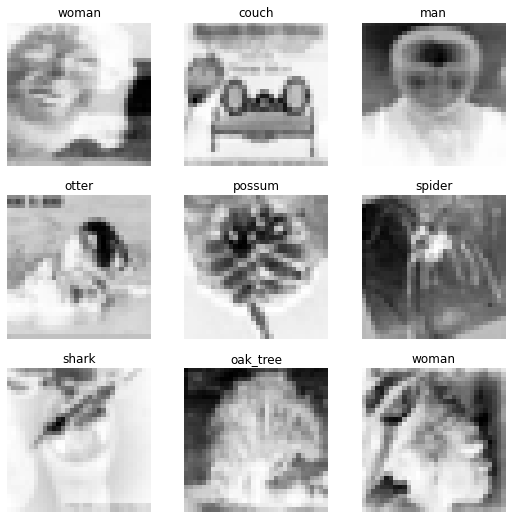

In [11]:
mixup = MixUp(0.5)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

##Label Smoothing

Label smoothing is a technique that spins out of the need for minimizing cross entropy in a multi-class classification problem.

In a multi-class classification, the cross entropy is used to calculate a softmax which assigns various probabilities that all add up to 1.

Ultimately, if cross entropy can be minimized, the model will be more sure of what it's predicting. Label smoothing achieves this by adding sharpness to inter-class boundary region. It smoothens each class space to have low intra cluster and high inter cluster distance

In [12]:
# https://amaarora.github.io/2020/07/18/label-smoothing.html
# https://forums.fast.ai/t/is-label-smoothing-off-by-eps-n/44290 
# https://github.com/fastai/fastai/blob/d2f9402dea39748b97f07a5845c74de50b8228d5/fastai/layers.py#L365

In [13]:
from fastai.layers import LabelSmoothingCrossEntropy

In [14]:
# X: Model Logits or outputs for each class (cat/dog)
# y: true labels
X = torch.tensor([[4.2, -2.4], [1.6, -0.6], [3.6, 1.2], [-0.5, 0.5], [-0.25, 1.7]])
y = torch.tensor([0, 1, 1, 0, 0])

In [15]:
LabelSmoothingCrossEntropy(eps=0.1, reduction='none')(X, y)

tensor([0.3314, 2.1951, 2.3668, 1.2633, 1.9855])

##Cutout

Cut out is a data augmentation technique where parts of the image are "cut out" or dropped. It has other variations such as cutmix, etc.

Here we use cutout_gaussian which is a part of the RandomErasing set of methods defined in the paper: https://arxiv.org/pdf/1708.04896.pdf

ref: https://docs.fast.ai/vision.augment#RandomErasing

In [18]:
!wget https://dogtime.com/assets/uploads/2018/10/puppies-cover-1280x720.jpg
img = PILImage(PILImage.create("./puppies-cover-1280x720.jpg").resize((600,400)))

--2020-09-19 21:31:08--  https://dogtime.com/assets/uploads/2018/10/puppies-cover-1280x720.jpg
Resolving dogtime.com (dogtime.com)... 104.17.69.15, 104.17.70.15
Connecting to dogtime.com (dogtime.com)|104.17.69.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106567 (104K) [image/jpeg]
Saving to: ‘puppies-cover-1280x720.jpg.1’

puppies-cover-1280x 100%[===================>] 104.07K  --.-KB/s    in 0.008s  

2020-09-19 21:31:08 (12.7 MB/s) - ‘puppies-cover-1280x720.jpg.1’ saved [106567/106567]



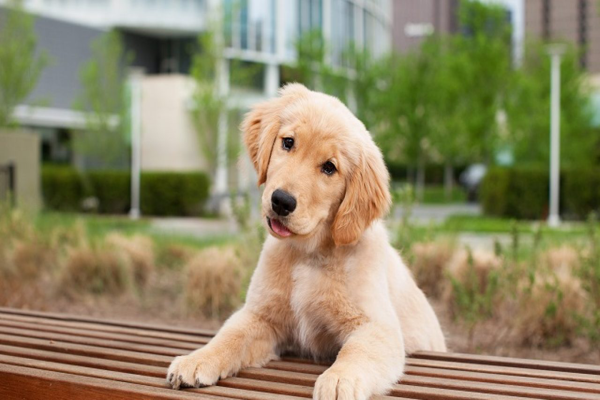

In [19]:
img

In [28]:
# Convert the image to tensor format and normalize it
timg = TensorImage(array(img)).permute(2,0,1).float()/255.
# Normalize image based on imagenet stats (pre-included in fastai)
nrm = Normalize.from_stats(*imagenet_stats, cuda=False)

In [24]:
# includes the cutout_gaussian method
from fastai.vision.augment import *

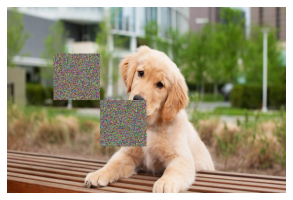

In [29]:
# used the areas values based on the example in fastai docs
f = partial(cutout_gaussian, areas=[(100,200,100,200),(200,300,200,300)])
show_image(norm_apply_denorm(timg, f, nrm)[0]);

##Test Time Augmentation

Here we compare accuracy during learning and use the same model to predict on a "test time agumented" image. A slight improvement in accuracy can be seen

In [3]:
path = untar_data(URLs.IMAGENETTE)

In [3]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

In [4]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.647459,2.600379,0.386482,02:40
1,1.214345,1.532369,0.546303,02:38
2,0.937018,1.228152,0.654220,02:36
3,0.710334,0.605156,0.811053,02:36
4,0.570192,0.523576,0.830844,02:33


In [5]:
x, y = dls.one_batch()
x.mean(dim=[0, 2, 3]), x.std(dim=[0, 2, 3])

(TensorImage([0.4598, 0.4674, 0.4643], device='cuda:0'),
 TensorImage([0.2919, 0.2850, 0.3156], device='cuda:0'))

In [6]:
preds,targs = learn.tta() # runs test time augmentation while classifying
accuracy(preds, targs).item()

0.8398058414459229

As we can see, the test time augmentation provides slightly better accuracy than our fit on the first cycle.

The key thing with TTA is during inference, or validation, create multiple versions of each image, using data augmentation, and then taking average of maximum of the predictions for each augmented version of the image. 